In [1]:
!pip install torchinfo

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
data_dir = "/kaggle/input/fish-data-raw/Fish Data raw/Fish Data"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Rui, Count: 2500
Class: Taki, Count: 2223
Class: Telapiya, Count: 2058
Class: Mrigel, Count: 1808
Class: Aair, Count: 1804
Class: Katla, Count: 1765
Class: Pabda, Count: 1764
Class: Boal, Count: 1651
Class: Puti, Count: 1560
Class: Tengra, Count: 1431
Class: Shol, Count: 1424
Class: Tarabaim, Count: 1262
Class: Ilish, Count: 1031
Class: Pangas, Count: 934
Class: KalBaush, Count: 917
Class: Koi, Count: 842
Class: Magur, Count: 574
Class: Foli, Count: 562
Class: Chapila, Count: 428
Class: DeshiPuti, Count: 412


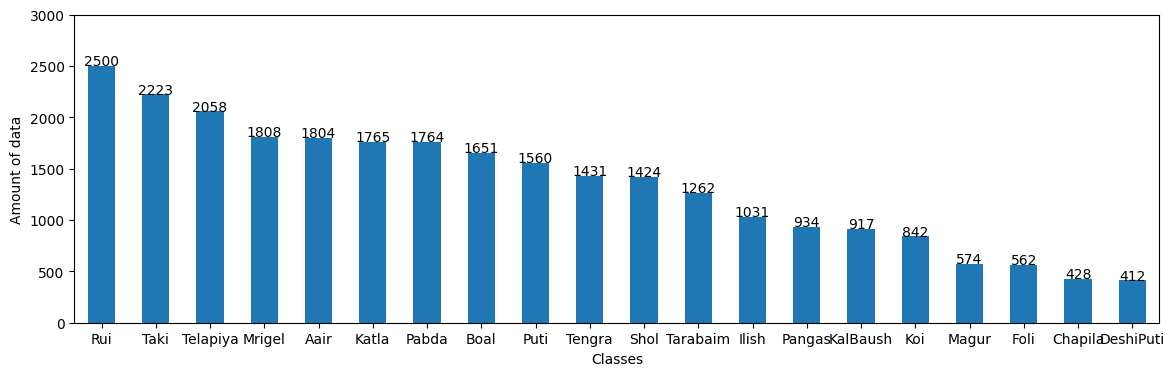

In [6]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(14, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

In [ ]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [8]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [9]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18865
Validation Data:  4042
Test Data:  4043
-------------------------------------------
Total amounts of data in the dataset:  26950


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [12]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        class_names = sorted(self.dataframe['label'].unique())  # Ensure consistent order
        self.label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [13]:
normalize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ImageDataset(train_dataframe, normalize, is_lb=True)
print(train_dataset.label_map)

{'Aair': 0, 'Boal': 1, 'Chapila': 2, 'DeshiPuti': 3, 'Foli': 4, 'Ilish': 5, 'KalBaush': 6, 'Katla': 7, 'Koi': 8, 'Magur': 9, 'Mrigel': 10, 'Pabda': 11, 'Pangas': 12, 'Puti': 13, 'Rui': 14, 'Shol': 15, 'Taki': 16, 'Tarabaim': 17, 'Telapiya': 18, 'Tengra': 19}


In [14]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

# GoogleNet   

In [15]:
from torchvision.models import googlenet

total_class = 20     # output
learning_rate = 0.0001

# ✅ Load pretrained GoogLeNet
model = googlenet(pretrained=True)

# ✅ Freeze layers
for param in model.parameters():
    param.requires_grad = False

# ✅ Replace final FC layer
model.fc = nn.Linear(model.fc.in_features, total_class)

model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Print model summary
summary(model, input_size=(train_batch, 3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 191MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [32, 20]                  --
├─BasicConv2d: 1-1                       [32, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                  [32, 64, 112, 112]        (128)
├─MaxPool2d: 1-2                         [32, 64, 56, 56]          --
├─BasicConv2d: 1-3                       [32, 64, 56, 56]          --
│    └─Conv2d: 2-3                       [32, 64, 56, 56]          (4,096)
│    └─BatchNorm2d: 2-4                  [32, 64, 56, 56]          (128)
├─BasicConv2d: 1-4                       [32, 192, 56, 56]         --
│    └─Conv2d: 2-5                       [32, 192, 56, 56]         (110,592)
│    └─BatchNorm2d: 2-6                  [32, 192, 56, 56]         (384)
├─MaxPool2d: 1-5                         [32, 192, 28, 28]         --
├─Inception: 1-6                         [32, 256, 28, 28] 

In [16]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=30, early_stop_patience=5, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/30: 100%|██████████| 590/590 [02:23<00:00,  4.11it/s, acc=0.382, loss=2.37]

Training Loss: 2.371 Acc: 0.382


Validation Loss: 1.853 Acc: 0.671
Best model saved at epoch 1 with validation accuracy: 0.671


Epoch 2/30: 100%|██████████| 590/590 [01:26<00:00,  6.84it/s, acc=0.708, loss=1.61]

Training Loss: 1.614 Acc: 0.708


Validation Loss: 1.294 Acc: 0.808
Best model saved at epoch 2 with validation accuracy: 0.808


Epoch 3/30: 100%|██████████| 590/590 [01:24<00:00,  6.96it/s, acc=0.786, loss=1.21]

Training Loss: 1.214 Acc: 0.786


Validation Loss: 0.992 Acc: 0.841
Best model saved at epoch 3 with validation accuracy: 0.841


Epoch 4/30: 100%|██████████| 590/590 [01:26<00:00,  6.83it/s, acc=0.824, loss=0.981]

Training Loss: 0.981 Acc: 0.824


Validation Loss: 0.813 Acc: 0.858
Best model saved at epoch 4 with validation accuracy: 0.858


Epoch 5/30: 100%|██████████| 590/590 [01:25<00:00,  6.92it/s, acc=0.845, loss=0.824]

Training Loss: 0.824 Acc: 0.845


Validation Loss: 0.684 Acc: 0.885
Best model saved at epoch 5 with validation accuracy: 0.885


Epoch 6/30: 100%|██████████| 590/590 [01:25<00:00,  6.87it/s, acc=0.865, loss=0.712]

Training Loss: 0.712 Acc: 0.865


Validation Loss: 0.590 Acc: 0.896
Best model saved at epoch 6 with validation accuracy: 0.896


Epoch 7/30: 100%|██████████| 590/590 [01:25<00:00,  6.92it/s, acc=0.876, loss=0.635]

Training Loss: 0.635 Acc: 0.876


Validation Loss: 0.526 Acc: 0.903
Best model saved at epoch 7 with validation accuracy: 0.903


Epoch 8/30: 100%|██████████| 590/590 [01:24<00:00,  6.96it/s, acc=0.882, loss=0.577]

Training Loss: 0.577 Acc: 0.882


Validation Loss: 0.472 Acc: 0.916
Best model saved at epoch 8 with validation accuracy: 0.916


Epoch 9/30: 100%|██████████| 590/590 [01:26<00:00,  6.85it/s, acc=0.893, loss=0.526]

Training Loss: 0.526 Acc: 0.893


Validation Loss: 0.431 Acc: 0.921
Best model saved at epoch 9 with validation accuracy: 0.921


Epoch 10/30: 100%|██████████| 590/590 [01:25<00:00,  6.90it/s, acc=0.897, loss=0.494]

Training Loss: 0.494 Acc: 0.897


Validation Loss: 0.394 Acc: 0.926
Best model saved at epoch 10 with validation accuracy: 0.926


Epoch 11/30: 100%|██████████| 590/590 [01:24<00:00,  6.98it/s, acc=0.902, loss=0.459]

Training Loss: 0.459 Acc: 0.902


Validation Loss: 0.370 Acc: 0.927
Best model saved at epoch 11 with validation accuracy: 0.927


Epoch 12/30: 100%|██████████| 590/590 [01:24<00:00,  6.96it/s, acc=0.906, loss=0.428]

Training Loss: 0.428 Acc: 0.906


Validation Loss: 0.342 Acc: 0.932
Best model saved at epoch 12 with validation accuracy: 0.932


Epoch 13/30: 100%|██████████| 590/590 [01:24<00:00,  6.96it/s, acc=0.914, loss=0.401]

Training Loss: 0.401 Acc: 0.914


Validation Loss: 0.322 Acc: 0.931


Epoch 14/30: 100%|██████████| 590/590 [01:26<00:00,  6.81it/s, acc=0.916, loss=0.383]

Training Loss: 0.383 Acc: 0.916


Validation Loss: 0.301 Acc: 0.937
Best model saved at epoch 14 with validation accuracy: 0.937


Epoch 15/30: 100%|██████████| 590/590 [01:24<00:00,  6.97it/s, acc=0.918, loss=0.364]

Training Loss: 0.364 Acc: 0.918


Validation Loss: 0.291 Acc: 0.939
Best model saved at epoch 15 with validation accuracy: 0.939


Epoch 16/30: 100%|██████████| 590/590 [01:26<00:00,  6.85it/s, acc=0.918, loss=0.353]

Training Loss: 0.353 Acc: 0.918


Validation Loss: 0.271 Acc: 0.944
Best model saved at epoch 16 with validation accuracy: 0.944


Epoch 17/30: 100%|██████████| 590/590 [01:27<00:00,  6.77it/s, acc=0.921, loss=0.339]

Training Loss: 0.339 Acc: 0.921


Validation Loss: 0.264 Acc: 0.944
Best model saved at epoch 17 with validation accuracy: 0.944


Epoch 18/30: 100%|██████████| 590/590 [01:26<00:00,  6.82it/s, acc=0.925, loss=0.323]

Training Loss: 0.323 Acc: 0.925


Validation Loss: 0.253 Acc: 0.945
Best model saved at epoch 18 with validation accuracy: 0.945


Epoch 19/30: 100%|██████████| 590/590 [01:25<00:00,  6.89it/s, acc=0.929, loss=0.314]

Training Loss: 0.314 Acc: 0.929


Validation Loss: 0.242 Acc: 0.950
Best model saved at epoch 19 with validation accuracy: 0.950


Epoch 20/30: 100%|██████████| 590/590 [01:26<00:00,  6.80it/s, acc=0.928, loss=0.304]

Training Loss: 0.304 Acc: 0.928


Validation Loss: 0.233 Acc: 0.950


Epoch 21/30: 100%|██████████| 590/590 [01:25<00:00,  6.89it/s, acc=0.928, loss=0.297]

Training Loss: 0.297 Acc: 0.928


Validation Loss: 0.226 Acc: 0.952
Best model saved at epoch 21 with validation accuracy: 0.952


Epoch 22/30: 100%|██████████| 590/590 [01:25<00:00,  6.91it/s, acc=0.932, loss=0.283]

Training Loss: 0.283 Acc: 0.932


Validation Loss: 0.217 Acc: 0.954
Best model saved at epoch 22 with validation accuracy: 0.954


Epoch 23/30: 100%|██████████| 590/590 [01:24<00:00,  6.95it/s, acc=0.935, loss=0.278]

Training Loss: 0.278 Acc: 0.935


Validation Loss: 0.212 Acc: 0.955
Best model saved at epoch 23 with validation accuracy: 0.955


Epoch 24/30: 100%|██████████| 590/590 [01:25<00:00,  6.92it/s, acc=0.934, loss=0.27] 

Training Loss: 0.270 Acc: 0.934


Validation Loss: 0.204 Acc: 0.956
Best model saved at epoch 24 with validation accuracy: 0.956


Epoch 25/30: 100%|██████████| 590/590 [01:25<00:00,  6.92it/s, acc=0.935, loss=0.266]

Training Loss: 0.266 Acc: 0.935


Validation Loss: 0.200 Acc: 0.956
Best model saved at epoch 25 with validation accuracy: 0.956


Epoch 26/30: 100%|██████████| 590/590 [01:24<00:00,  7.01it/s, acc=0.936, loss=0.262]

Training Loss: 0.262 Acc: 0.936


Validation Loss: 0.196 Acc: 0.956


Epoch 27/30: 100%|██████████| 590/590 [01:24<00:00,  7.00it/s, acc=0.939, loss=0.253]

Training Loss: 0.253 Acc: 0.939


Validation Loss: 0.188 Acc: 0.960
Best model saved at epoch 27 with validation accuracy: 0.960


Epoch 28/30: 100%|██████████| 590/590 [01:25<00:00,  6.86it/s, acc=0.938, loss=0.246]

Training Loss: 0.246 Acc: 0.938


Validation Loss: 0.184 Acc: 0.959


Epoch 29/30: 100%|██████████| 590/590 [01:25<00:00,  6.88it/s, acc=0.94, loss=0.243] 

Training Loss: 0.243 Acc: 0.940


Validation Loss: 0.181 Acc: 0.962
Best model saved at epoch 29 with validation accuracy: 0.962


Epoch 30/30: 100%|██████████| 590/590 [01:23<00:00,  7.07it/s, acc=0.937, loss=0.243]

Training Loss: 0.243 Acc: 0.937


Validation Loss: 0.174 Acc: 0.959
Training Time: 3215.14 seconds ---> 53.59 minutes


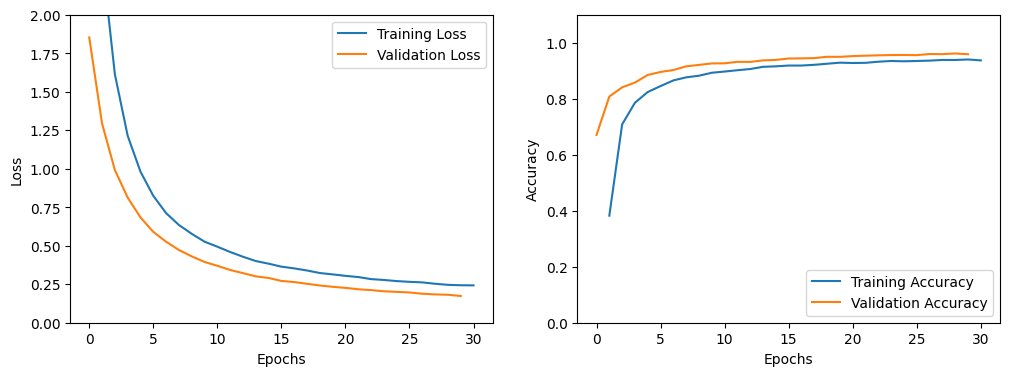

In [17]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

In [18]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [19]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.5f}")

Best model (from epoch 29) - Validation Loss: 0.181, Validation Accuracy: 0.96165


In [20]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.956
Test Time: 32.57 seconds ---> 0.54 minutes


In [21]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       271
           1       0.90      0.97      0.93       248
           2       0.98      0.98      0.98        64
           3       0.98      0.97      0.98        62
           4       0.97      0.99      0.98        84
           5       0.99      0.95      0.97       154
           6       0.90      0.99      0.94       137
           7       0.97      0.94      0.95       265
           8       0.99      1.00      1.00       126
           9       1.00      1.00      1.00        86
          10       0.96      0.97      0.96       272
          11       0.99      0.94      0.97       265
          12       0.98      0.98      0.98       140
          13       0.97      0.97      0.97       234
          14       0.95      0.90      0.92       375
          15       0.90      0.94      0.92       213
          16       0.94      0.93      0.94       334
    